In [4]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [5]:
import numpy as np
import pandas as pd

# Anomalies

In this homework we will look at some simple examples of detecting anomalies in time series. But first, let's try to define, what anomaly is.

In general, **anomaly** is an observable behaviour of the system, which contradicts the underlying dynamics, which we believe is driving the system. Of course, any observable, normal or anomalous, is generated by underlying system dynamics. The real reason we consider some behaviours as normal and some as anomalous is that we use not a real dynamics to describe the system, but either some model, or we want system to demostrate certain desired behaviour.

For example:

- unusually high power consumption in electrical grid may be caused by unusual weather conditions for a certain season, and is thus an absolutely explainable, but grid operator still considers this situation as an anomaly, because unusually high consumption is not a desirable behaviour,
- presense of unusual patterns in sensor reading of industrial equipment may be an indication of some failure coming. In this case, anomaly is not manifested as some extremely high or low way, but rather as an unusual pattern.

In this homework we will consider two datasets:

- [hourly energy consumption data from PJM transmission operator](https://www.kaggle.com/robikscube/hourly-energy-consumption),
- ECG data from [MIT-BIH Arrhythmia Database](https://www.kaggle.com/mondejar/mitbih-database).

# Data

For the first exercise, we will take specific area, served by Commonwealth Edison energy producer. The area is Chicago and part of Illinois. We will look at the data to understand, when consumption is anomalous and will try to explain this anomalies to some extent.

Mounting the drive (Hadas)

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Entering the directory (Hadas)

In [7]:
#cd drive/MyDrive/Y-data/Unsupervised/L5-anomaly-detect/UL-anomaly_detection_data

/content/drive/MyDrive/Y-data/Unsupervised/L5-anomaly-detect/UL-anomaly_detection_data


In [8]:
data = pd.read_csv('COMED_hourly.csv',
                   parse_dates=["Datetime"],
                   index_col="Datetime")

In [9]:
data.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


Let's clean-up the field a bit first:

In [10]:
data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"
data.head()

,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


## Quick exploration

Data definitely demostrates strong seasonality with consumption being higher at summer (air conditioning, apperantly) and during winter (electrical heating, lights etc.):

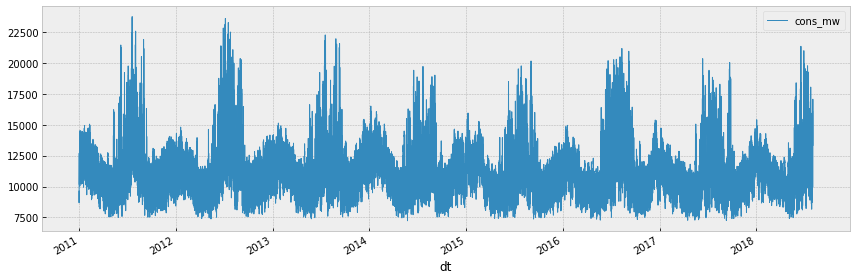

In [11]:
plt.figure(figsize=(12,4))
data.plot(linewidth=1, ax=plt.gca())
plt.tight_layout()

If we try to calculate rolling average of the data, we will fail, cause original data is not ordered:

In [12]:
data=data.sort_index()
data.rolling("7D").mean()

,cons_mw
dt,
2011-01-01 01:00:00,9631.000000
2011-01-01 02:00:00,9452.000000
2011-01-01 03:00:00,9305.000000
2011-01-01 04:00:00,9164.000000
2011-01-01 05:00:00,9070.000000
...,...
2018-08-02 20:00:00,12035.815476
2018-08-02 21:00:00,12045.607143
2018-08-02 22:00:00,12054.297619


# Naive anomalies detection

The first and the most simple way to catch unusually high or low values is to just look at rolling average and rolling standard deviation. The assumation is that for a reasonably short period we can use usual statistical approaches, and to say
> if it's outside 3$\sigma$, it's an anomaly

is still somewhat reliable. Let's look at the data at a weekly scale:

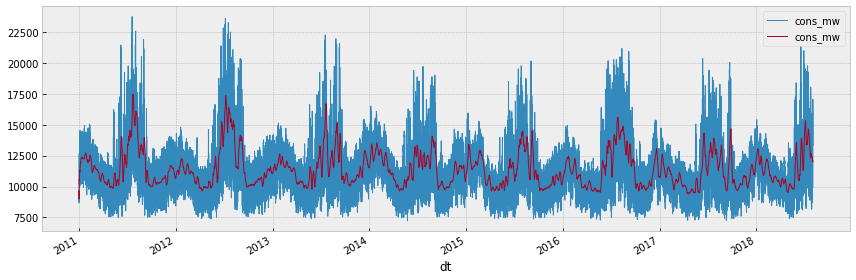

In [13]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

data.rolling("7D").mean().plot(linewidth=1, ax=plt.gca())

plt.legend(loc=0)
plt.tight_layout()

If we look at the same data on a monthly scale and add "normal" range ($3\sigma$ from rolling average in any direction), we'll start to see hours, which go to high:

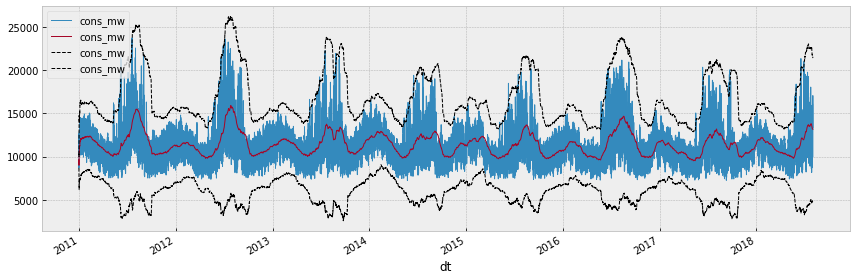

In [14]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

(data
 .rolling("30D")
 .mean()
 .plot(linewidth=1, ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()+3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()-3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

plt.legend(loc=0)
plt.tight_layout()

Let's create a funtion, which searches for such points and creates new dataframe with anomaly indication:

In [15]:
def detect_anomalies(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [16]:
data_an = detect_anomalies(data["cons_mw"], "30D", 3.)

In [17]:
data_an.head()

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.0,NaN,0
2011-01-01 02:00:00,9273.0,9452.0,253.144228,0
2011-01-01 03:00:00,9011.0,9305.0,311.236245,0
2011-01-01 04:00:00,8741.0,9164.0,379.608570,0
2011-01-01 05:00:00,8694.0,9070.0,390.201230,0


In [18]:
def plot_anomalies(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plot anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="yellow", linestyle="--",  ax=plt.gca())


    plt.tight_layout()

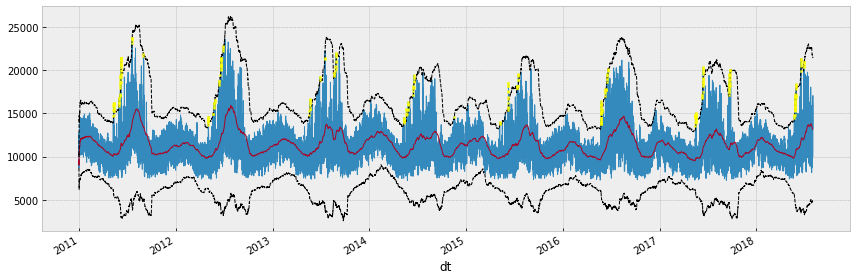

In [19]:
plot_anomalies(data_an, "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

Although some of the caught anomalies look ok, we immediately can spot several problems:
    
- we definitely underestimate the upper bound of the range, when rolling average goes up very fast,
- we definitely overestimate the upper bound of the range, when rolling average goes down very fast.

This all happens because rolling average is "delayed" relative to underlying time series. Another, probably more severe, problem is non-stationarity, and especially seasonality. Depending on the structure, by doing such a naive anomaly detection we may miss a lot of real anomalies. Can we do better?

# Extracting trends and seasonality

To make our anomaly search more robust, we can remove trend (if any) and seasonality from the time series:

$$series = trend + seasonality + residuals$$.

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
result = seasonal_decompose(data["cons_mw"], freq=365*24)
result.resid

<ipython-input-21-a2588e4531e2>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(data["cons_mw"], freq=365*24)


dt
2011-01-01 01:00:00   NaN
2011-01-01 02:00:00   NaN
2011-01-01 03:00:00   NaN
2011-01-01 04:00:00   NaN
2011-01-01 05:00:00   NaN
                       ..
2018-08-02 20:00:00   NaN
2018-08-02 21:00:00   NaN
2018-08-02 22:00:00   NaN
2018-08-02 23:00:00   NaN
2018-08-03 00:00:00   NaN
Name: resid, Length: 66497, dtype: float64

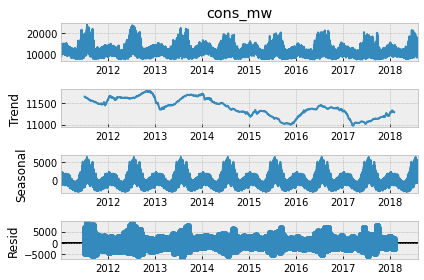

In [22]:
result.plot()
plt.show()

Looks interesting: we have very pronounced seasonality and a lot of information, not covered by season at all (residuals are of the same range, as seasonal component). This may drive us to conclusion, that we can use residuals as the new series for anomaly detection. Let's try.

In [23]:
(result.resid).value_counts()


 3331.742116    1
-180.773507     1
 425.825515     1
 153.110724     1
-63.467065      1
               ..
 4033.544171    1
 4331.822278    1
 4449.418242    1
 4039.435985    1
 875.875466     1
Name: resid, Length: 57737, dtype: int64

In [24]:
residual_anomalies = detect_anomalies(result.resid.rename("cons_mw_res"), "30D", 3.)

In [25]:
residual_anomalies

,cons_mw_res,cons_mw_res_rmean,cons_mw_res_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,NaN,NaN,NaN,0
2011-01-01 02:00:00,NaN,NaN,NaN,0
2011-01-01 03:00:00,NaN,NaN,NaN,0
2011-01-01 04:00:00,NaN,NaN,NaN,0
2011-01-01 05:00:00,NaN,NaN,NaN,0
...,...,...,...,...
2018-08-02 20:00:00,NaN,NaN,NaN,0
2018-08-02 21:00:00,NaN,NaN,NaN,0
2018-08-02 22:00:00,NaN,NaN,NaN,0


In [26]:
data_an.iloc[:, :-1]

,cons_mw,cons_mw_rmean,cons_mw_rstd
dt,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN
2011-01-01 02:00:00,9273.0,9452.000000,253.144228
2011-01-01 03:00:00,9011.0,9305.000000,311.236245
2011-01-01 04:00:00,8741.0,9164.000000,379.608570
2011-01-01 05:00:00,8694.0,9070.000000,390.201230
...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713


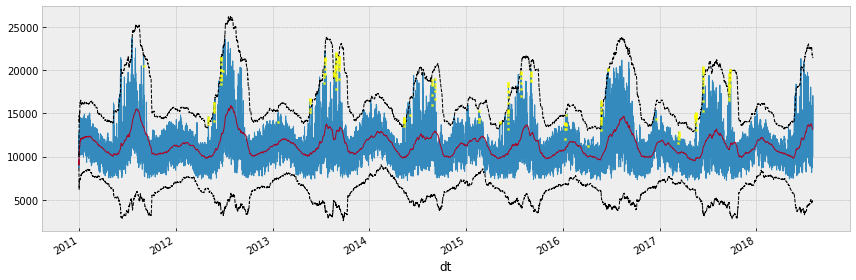

In [27]:
plot_anomalies(data_an.iloc[:, :-1].join(residual_anomalies["anomaly"]),
               "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

What is interesting, is that locations anomalies are different.

# Next steps

Can we somehow explain the anomalies? Or validate them? Yes, we can. Using the [historical weather dataset](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#city_attributes.csv), we can look, whether temperature explains anomalies to some extent and then improve our anomaly detection algrithm.

In [28]:
temp_data = pd.read_csv("temperature.csv", parse_dates=["datetime"],
                        usecols=["datetime", "Chicago"], index_col="datetime")
temp_data.head()

,Chicago
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,284.010000
2012-10-01 14:00:00,284.054691
2012-10-01 15:00:00,284.177412
2012-10-01 16:00:00,284.300133


In [29]:
data_an

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN,0
2011-01-01 02:00:00,9273.0,9452.000000,253.144228,0
2011-01-01 03:00:00,9011.0,9305.000000,311.236245,0
2011-01-01 04:00:00,8741.0,9164.000000,379.608570,0
2011-01-01 05:00:00,8694.0,9070.000000,390.201230,0
...,...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596,0
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103,0
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713,0


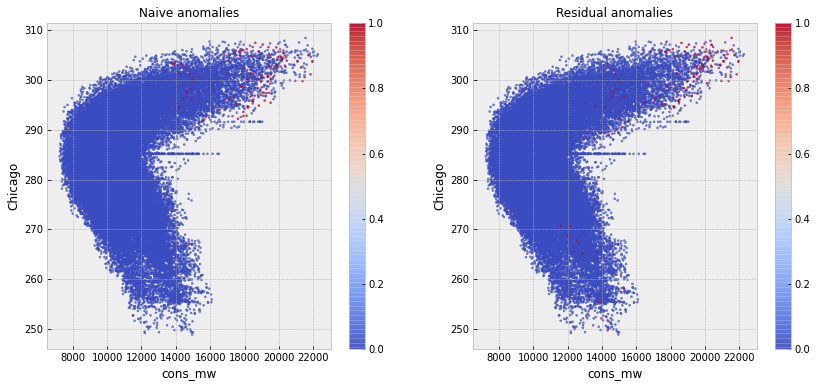

In [30]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

Btw, can you extract season (summer/winter) from this images? Try to play with some clustering here.

Using KMeans

Text(0.5, 1.0, 'Kmeans clustering')

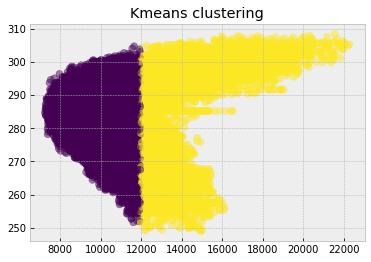

In [31]:
from sklearn.cluster import KMeans

df = naive_anomalies[['cons_mw', 'Chicago']].copy()
df.dropna(axis=0, inplace=True) # Removing rows with Nans
kmeans = KMeans(n_clusters=2).fit(df)

plt.scatter(df['cons_mw'], df['Chicago'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.title('Kmeans clustering')

Using DBSCAN

Estimated no. of clusters:	 9
Estimated no. of noise points:	 45238


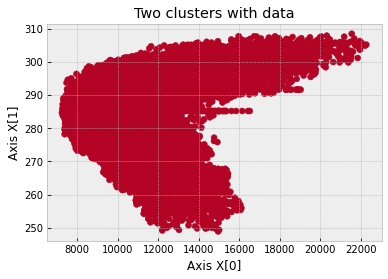

In [32]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(df)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters:\t', no_clusters)
print('Estimated no. of noise points:\t', no_noise)

# Generate scatter plot for training data
colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', labels))
plt.scatter(df['cons_mw'], df['Chicago'], c=colors, marker="o", picker=True)
plt.title('Two clusters with data')
plt.xlabel('Axis X[0]')
plt.ylabel('Axis X[1]')
plt.show()

We didn't succeed to cluster our data by seasons with either KMean or DBScan.

## Intermediate conclusions

We can make two conslusions from the plots above:

- temperature alone is a strong influencer of energy consumption,
- thus, some of the anomalies, that we detected looking only at consumption, are perfectly ok, if you add temperature into consideration.

Let's improve our detection approach, and look at both consumption and temperature. For this, we will use algorithm called Local Outlier Factor detection. In a simple terms, it looks at local density, and tryis to estimate, how strongly a point is embedded into the data.

In [34]:
from sklearn.neighbors import LocalOutlierFactor

In [35]:
en_temp = temp_data.join(data_an)[["Chicago", "cons_mw"]]

In [36]:
en_temp = en_temp[~en_temp.isnull().any(axis=1)]
en_temp

,Chicago,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2017-11-29 20:00:00,281.340000,12171.0
2017-11-29 21:00:00,281.690000,11998.0
2017-11-29 22:00:00,281.070000,11681.0
2017-11-29 23:00:00,280.060000,11148.0


Let's try default parameters first:

In [37]:
detector = LocalOutlierFactor()
factors = detector.fit_predict(en_temp)

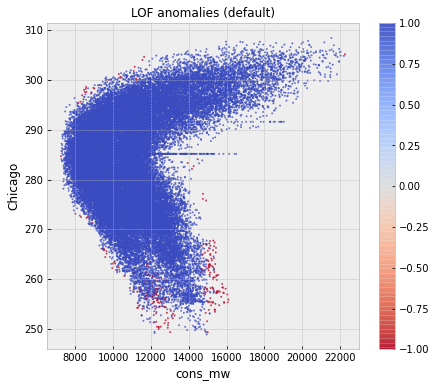

In [38]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Not that bad, but it looks like our detector is a bit too harsh. Let's make it softer:

In [39]:
soft_detector = LocalOutlierFactor(contamination=0.025, n_neighbors=10)
factors = soft_detector.fit_predict(en_temp)

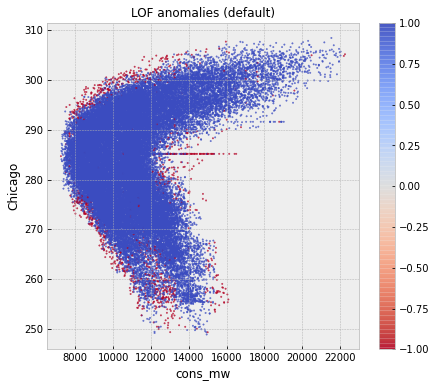

In [40]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Contamination parameter defines, how many outliers we have in the data. `0.025` means `once in 40 hours`, which is reasonable, but depends, of course, on which grid operator we consider.

Now that we looked at basics of outlier/anomaly detection, you can play with it further, for example, try IsolationForest algorithm. You may benefit from reading the discussion on how outlier is different from novelty at [`sklearn` User guide](https://scikit-learn.org/stable/modules/outlier_detection.html).

### Using Isolation Forest

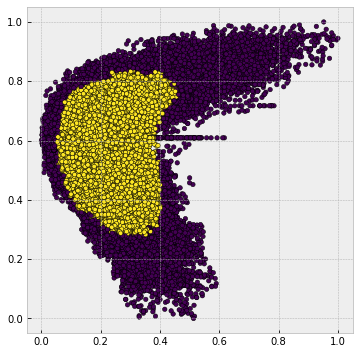

In [41]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(7,6))

X = df[["cons_mw","Chicago"]].to_numpy()

# Standarizing
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# Fitting
clf = IsolationForest(random_state=0).fit(X)  

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=clf.predict(X), s=20, edgecolor="k")
plt.axis("square")
plt.show()

It seems that the IsoltionForest model defined too many of our samples as outliers.

# Structural anomalies

Although you often can spot anomalies just by values, it often happens that anomalies are hidden in data structure. For example, peak frequency of the signal changes, which is sometimes quite hard to spot by eye, or some other **structural** changes take place.

In this case anomalies are detected in a more elaborate way. The most straightforward approach is to somehow quantify signal structure (power spectrum is a good example, as well as mean crossing rate).

We will not go deep into explanations of how this works from medical prospective, and will look at data itself mostly.

In [42]:
mit = pd.read_csv("234.csv")

In [43]:
mit.head()

,'sample #','MLII','V1'
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


In [44]:
mit.columns = ["sample", "MLII", "V1"]

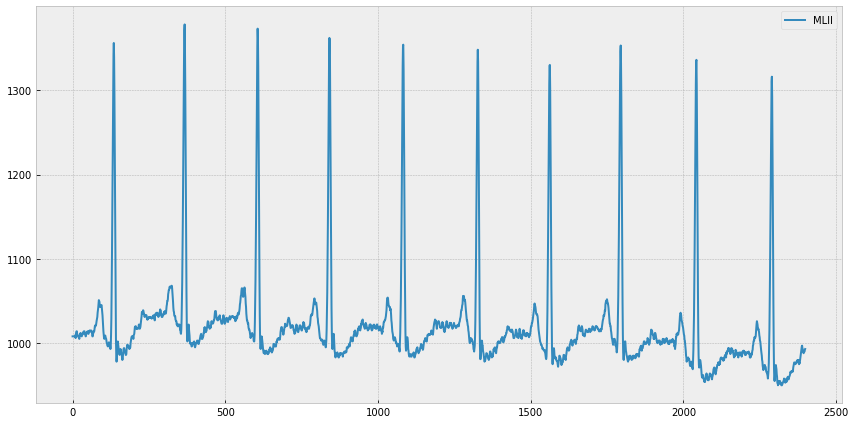

In [45]:
plt.figure(figsize=(12,6))
mit["MLII"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

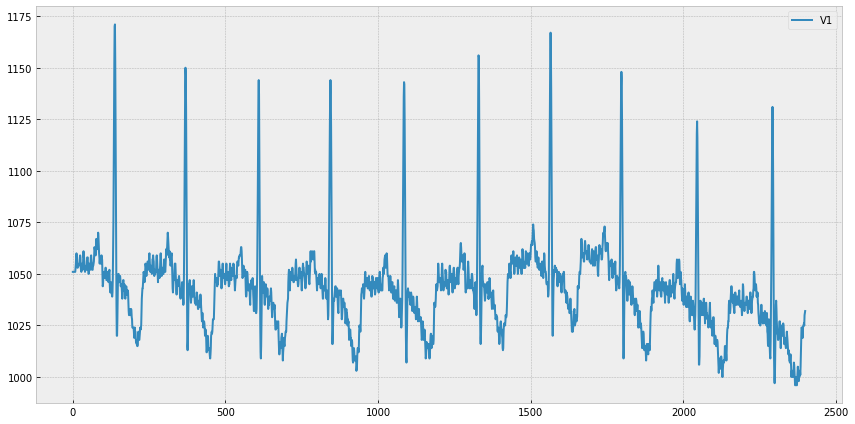

In [46]:
plt.figure(figsize=(12,6))
mit["V1"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

As you can see, data has very strong temporal pattern. Failure in following this pattern is an indication of underlying medical condition and can be detected automatically.

In [47]:
annotations = pd.read_csv("234annotations.txt", sep="\s+")

In [48]:
annotations.head()

,Time,Sample,#,Type,Sub,Chan,Num,Aux
0,0:00.144,52,+,0,0,0,(N,NaN
1,0:00.375,135,N,0,0,0,NaN,NaN
2,0:01.017,366,N,0,0,0,NaN,NaN
3,0:01.683,606,N,0,0,0,NaN,NaN
4,0:02.336,841,N,0,0,0,NaN,NaN


In [49]:
annotations.columns = ["timestamp", "sample", "type", "sub", "chan", "num", "aux", "smth"]

In [50]:
annotations = annotations[annotations.columns[:-1]]

In [51]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2764 non-null   object
 1   sample     2764 non-null   int64 
 2   type       2764 non-null   object
 3   sub        2764 non-null   int64 
 4   chan       2764 non-null   int64 
 5   num        2764 non-null   int64 
 6   aux        3 non-null      object
dtypes: int64(4), object(3)
memory usage: 151.3+ KB


In [52]:
annotations['aux'].value_counts()

(N       2
(SVTA    1
Name: aux, dtype: int64

There are many approaches to detection of structural anomalies. Depending on the signal, we can

- **construct some aggreagates for rolling windows,** and do the same thing we did with energy consumption. For example, we may calculate peak frequency, or power in some specific spectral band. This approach works well for signals, which do not have strict repetitive structure, but generally have some normal parameters. For example, for rotating (motors, generators, and so on) industrial equipment drift in peak frequency may indicate problems,
- **construct some forecasting model,** and look at large deviations between forecasts and real values. This works well for a) signals with autoregressive structure (energy consumption is a good example), and hence the model is some kind of AR model (AR, VAR, ARIMA, whatever works), b) for signals with clear and repetitive structure (ECG and EEG are good examples), and in this case we need to build a nonlinear model for forecasting.

Since we have a signal with very strict temporal pattern, we may try to model it and look at divergence between what model predicts (i.e. the temporal structure model catched) and real values.

We will take last 50 values (this number is a bit out of the blue, but if you look at signal, you'll see, that it should be ok). 
This will basicly allow us to convert our time series into a "point anomaly" problem

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [54]:
train_signal = mit[:30000]
cv_signal = mit[:30050]
test_signal = mit[40050:50000]

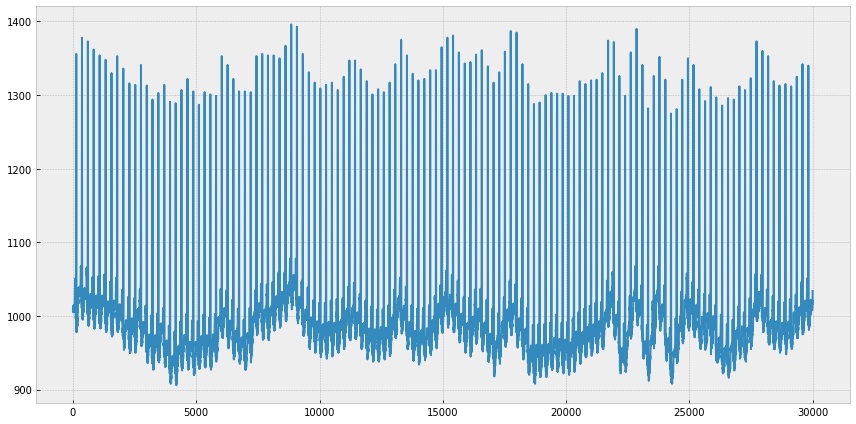

In [55]:
plt.figure(figsize=(12,6))
train_signal.MLII.plot()
plt.tight_layout()

We won't go into hyperparameters tuning, we only need to know, that our model cross-validaties.

In [56]:
WINDOW = 50

In [57]:
signal = mit[:15000]

In [58]:
features = {}

for i in signal.index[50:]:
    #print('i:', i, '\ti-WINDOW:i-1   ', i-WINDOW, ':',i-1)
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

In [59]:
print(features.shape)
features.head()

(14950, 100)


,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [60]:
model = RandomForestRegressor(n_estimators=500, max_depth=4)
model.fit(features[:7500], signal.loc[features[:7500].index, "V1"])

RandomForestRegressor(max_depth=4, n_estimators=500)

In [61]:
print("CV MSE:", mean_squared_error(model.predict(features[7500:10000]),
                                    signal.loc[features[7500:10000].index, "V1"]))

CV MSE: 31.816931505825394


Ok, looks like it works just fine, let's look at forecasts:

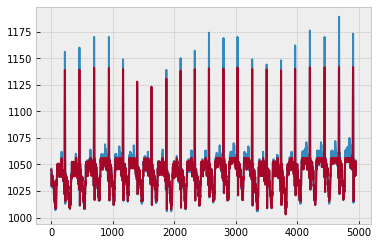

In [62]:
plt.plot(signal.loc[features[10000:].index, "V1"].values)
plt.plot(model.predict(features[10000:]))

We see, that model is not ideal, but we do not plan to use it directly. Instead, we will look at longer time intervals:

In [63]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[10000:].index, "V1"].values,
                                    model.predict(features[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features[10000:].index)

In [64]:
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

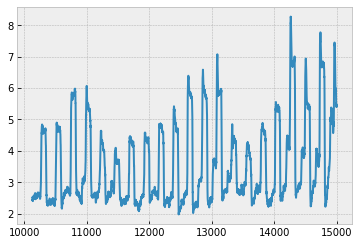

In [65]:
indicator["y_diff"].rolling(80).mean().plot()

Now, by thresholding the rolling averages difference between forecast and actual values, we can detect anomalous behaviour.

# Assignment

**Task 1 (_max score - 20 points_)** Calculate features for a longer period of time, so that the model can be trained to better match the real signal.

**Task 2 (_max score - 20 points_)** Calculate differences. Are they are ok to serve as anomaly detection?

**Task 3 (_max score - 20 points_)** Why we use rolling average instead of difference between forecast and actual values?

**Task 4 (_max score - 40 points_)** Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.

In the tasks 2-4, visualize your results (show the anomalous points).

## Task 1
Calculating features for a longer period of time, so that the model can be trained to better match the real signal.

Defining the signal and the window size

In [81]:
WINDOW = 80
signal = mit[:20000]

Calculating the features

In [82]:
features2 = {}

for i in signal.index[WINDOW:]:
    #print('i:', i, '\ti-WINDOW:i-1   ', i-WINDOW, ':',i-1)
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features2[i] = fts.loc[:, 0]
features2 = pd.DataFrame.from_dict(features2, orient="index")

Defining the new range of the training set

In [83]:
range = 10000
model2 = RandomForestRegressor(n_estimators=500, max_depth=4)
model2.fit(features2[:range], signal.loc[features2[:range].index, "V1"])

RandomForestRegressor(max_depth=4, n_estimators=500)

Comparing the two models' MSE

In [85]:
model1_range = 7500
model2_range = 10000
print("CV MSE the first model: ", mean_squared_error(model.predict(features[model1_range:model1_range+2500]),
                                    signal.loc[features[model1_range:model1_range+2500].index, "V1"]))
print("CV MSE the second model:", mean_squared_error(model2.predict(features2[model2_range:model2_range+2500]),
                                    signal.loc[features2[model2_range:model2_range+2500].index, "V1"]))

CV MSE the first model:  31.816931505825394
CV MSE the second model: 24.000205511782365


Comparing the MSE using the same test set

In [84]:
print("CV MSE the first model: ", mean_squared_error(model.predict(features[range:range+2500]),
                                    signal.loc[features[range:range+2500].index, "V1"]))
print("CV MSE the second model:", mean_squared_error(model2.predict(features2[range:range+2500]),
                                    signal.loc[features2[range:range+2500].index, "V1"]))

CV MSE the first model:  25.422646244051414
CV MSE the second model: 24.000205511782365


We can see an improvemnet using wider window and larger signal dataset, the MSE decreased. 

## Task 2
 Calculating differences 

Let's calculate the indicator datset using our new model

In [68]:
indicator2 = pd.DataFrame(np.vstack([signal.loc[features2[range+3000:].index, "V1"].values,
                                    model2.predict(features2[range+3000:])]).T,
                        columns = ["y_true", "y_pred"], index=features2[range+3000:].index)

In [69]:
indicator2["y_diff"] = (indicator2["y_true"]-indicator2["y_pred"]).abs()

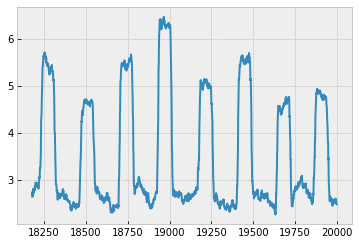

In [70]:
indicator2["y_diff"].rolling(80).mean().plot()

Let's calculate all the diffrences above some thresholds

In [71]:
dt = 4  # Different threshold
rw = 80  # Rolling window

indicator2_mean_rolling = indicator2.rolling(rw).mean()
indicator2_mean_rolling['diff_above_thresh'] = indicator2_mean_rolling.loc[indicator2_mean_rolling['y_diff'] > dt , 'y_diff']
indicator2_mean_rolling['diff_above_thresh'].fillna(value=0)
indicator2_mean_rolling

,y_true,y_pred,y_diff,diff_above_thresh
18100,NaN,NaN,NaN,NaN
18101,NaN,NaN,NaN,NaN
18102,NaN,NaN,NaN,NaN
18103,NaN,NaN,NaN,NaN
18104,NaN,NaN,NaN,NaN
...,...,...,...,...
19995,1026.5375,1026.639493,2.574017,NaN
19996,1026.7000,1026.737721,2.556859,NaN
19997,1026.9625,1026.861222,2.514336,NaN
19998,1027.2750,1027.148409,2.489022,NaN


Let's plot the result

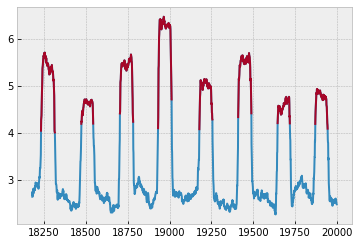

In [72]:
indicator2_mean_rolling['y_diff'].plot()
indicator2_mean_rolling['diff_above_thresh'].plot()

## Task 3

**Why we use rolling average instead of difference between forecast and actual values?**

The rolling average is used to smooth short-term fluctuations and make it easier to identify long-term patterns in the data and reveal the underline structure of the data. Therefore it is harder to detect anomalies using direct differences between forecast and actual values.

For example, let's see the differnce plot without using moving average

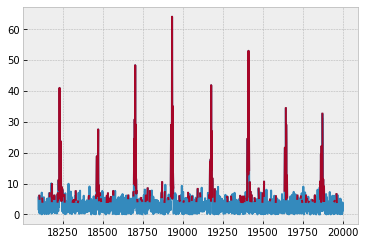

In [73]:
dt = 4  # Different threshold
rw = 1  # Rolling window

indicator2_no_rolling = indicator2.rolling(rw).mean()
indicator2_no_rolling['diff_above_thresh'] = indicator2_no_rolling.loc[indicator2_no_rolling['y_diff'] > dt , 'y_diff']
indicator2_no_rolling['diff_above_thresh'].fillna(value=0)
indicator2_no_rolling['y_diff'].plot()
indicator2_no_rolling['diff_above_thresh'].plot()

As we can see, when we do not use rolling window, the differences are many, and it is harder to detect anomalies.

## Task 4
Implementing the same approach to the energy consumption problem.

### Feature extraction

We will upload the energy consumption file and proccess it, following the example

In [86]:
data = pd.read_csv('COMED_hourly.csv',
                   parse_dates=["Datetime"],
                   index_col="Datetime")
data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"

data.head()

,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


In [87]:
data.shape

(66497, 1)

In [88]:
data.sort_index(inplace=True)
data

,cons_mw
dt,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0
...,...
2018-08-02 20:00:00,16437.0
2018-08-02 21:00:00,15590.0
2018-08-02 22:00:00,15086.0


In [89]:
WINDOW = 50
signal_ec = data[:15000]
signal_ec.reset_index(inplace=True)  # Removing the time stamp indexing for the feature extraction
signal_ec.head()


,dt,cons_mw
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0


In [90]:
features_ec = {}

for i in signal_ec.index[WINDOW:]:
    #print('i:', i, '\ti-WINDOW:i-1   ', i-WINDOW, ':',i-1)
    fts = (signal_ec.loc[i-WINDOW:i-1, ["cons_mw"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features_ec[i] = fts.loc[:, 0]
features_ec = pd.DataFrame.from_dict(features_ec, orient="index")

In [91]:
features_ec.head()

,cons_mw_0,cons_mw_1,cons_mw_2,cons_mw_3,cons_mw_4,cons_mw_5,cons_mw_6,cons_mw_7,cons_mw_8,cons_mw_9,...,cons_mw_40,cons_mw_41,cons_mw_42,cons_mw_43,cons_mw_44,cons_mw_45,cons_mw_46,cons_mw_47,cons_mw_48,cons_mw_49
50,9631.0,9273.0,9011.0,8741.0,8694.0,8711.0,8943.0,9222.0,9430.0,9670.0,...,11074.0,11929.0,12841.0,12956.0,12849.0,12689.0,12274.0,11662.0,10897.0,10494.0
51,9273.0,9011.0,8741.0,8694.0,8711.0,8943.0,9222.0,9430.0,9670.0,10125.0,...,11929.0,12841.0,12956.0,12849.0,12689.0,12274.0,11662.0,10897.0,10494.0,10279.0
52,9011.0,8741.0,8694.0,8711.0,8943.0,9222.0,9430.0,9670.0,10125.0,10538.0,...,12841.0,12956.0,12849.0,12689.0,12274.0,11662.0,10897.0,10494.0,10279.0,10165.0
53,8741.0,8694.0,8711.0,8943.0,9222.0,9430.0,9670.0,10125.0,10538.0,10782.0,...,12956.0,12849.0,12689.0,12274.0,11662.0,10897.0,10494.0,10279.0,10165.0,10199.0
54,8694.0,8711.0,8943.0,9222.0,9430.0,9670.0,10125.0,10538.0,10782.0,10861.0,...,12849.0,12689.0,12274.0,11662.0,10897.0,10494.0,10279.0,10165.0,10199.0,10440.0


### Fitting a random forest model

Let's fit the model

In [92]:
model_ec = RandomForestRegressor(n_estimators=500, max_depth=4)
model_ec.fit(features_ec[:7500], signal_ec.loc[features_ec[:7500].index, "cons_mw"])

RandomForestRegressor(max_depth=4, n_estimators=500)

Testin preformance

In [93]:
print("CV MSE:", mean_squared_error(model_ec.predict(features_ec[7500:10000]),
                                    signal_ec.loc[features_ec[7500:10000].index, "cons_mw"]))

CV MSE: 171177.57869890094


### Improving the model

The MSE is very large. Let's define a wider window and a larger signal

In [94]:
WINDOW = 30
LIMIT = 20000
signal_ec = data[:LIMIT]
signal_ec.reset_index(inplace=True)  # Removing the time stamp indexing for the feature extraction
signal_ec.head()

,dt,cons_mw
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0


In [95]:
features_ec = {}

for i in signal_ec.index[WINDOW:]:
    #print('i:', i, '\ti-WINDOW:i-1   ', i-WINDOW, ':',i-1)
    fts = (signal_ec.loc[i-WINDOW:i-1, ["cons_mw"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features_ec[i] = fts.loc[:, 0]
features_ec = pd.DataFrame.from_dict(features_ec, orient="index")

In [96]:
features_ec.shape

(19970, 30)

Fitting the model, using the default max_df

In [97]:
TRAIN_LIMIT = int(LIMIT*0.75)
model_ec = RandomForestRegressor(n_estimators=500)
model_ec.fit(features_ec[:TRAIN_LIMIT], signal_ec.loc[features_ec[:TRAIN_LIMIT].index, "cons_mw"])

RandomForestRegressor(n_estimators=500)

In [98]:
VAL_LIMIT = int(TRAIN_LIMIT + 2500)

print("CV MSE:", mean_squared_error(model_ec.predict(features_ec[TRAIN_LIMIT:VAL_LIMIT]),
                                    signal_ec.loc[features_ec[TRAIN_LIMIT:VAL_LIMIT].index, "cons_mw"]))

CV MSE: 19156.970146081603


We decreased the MSE from 170K to 20K

Plotting the forecast

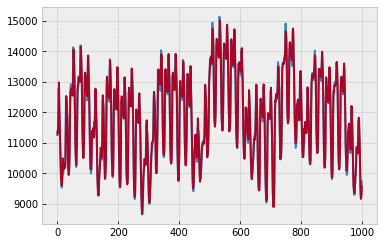

In [99]:
plt.plot(signal_ec.loc[features_ec[VAL_LIMIT:VAL_LIMIT+1000].index, "cons_mw"].values)
plt.plot(model_ec.predict(features_ec[VAL_LIMIT:VAL_LIMIT+1000]))

We can see that overall, the predictions are quite good.

Let's calculate the indicator function

In [100]:
indicator_ec = pd.DataFrame(np.vstack([signal_ec.loc[features_ec[VAL_LIMIT:].index, "cons_mw"].values,
                                    model_ec.predict(features_ec[VAL_LIMIT:])]).T,
                        columns = ["y_true", "y_pred"], index=features_ec[VAL_LIMIT:].index)

In [101]:
indicator_ec["y_diff"] = (indicator_ec["y_true"]-indicator_ec["y_pred"]).abs()

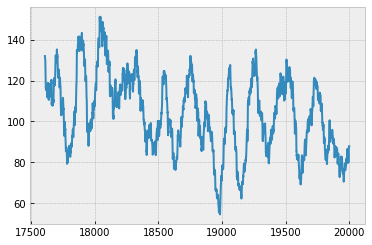

In [102]:
indicator_ec["y_diff"].rolling(80).mean().plot()

We can see that the differences are in cycles. Maybe our model misses periodic data. Lets try to optimize our model using more window sizes.

In [103]:
def extract_and_fit(ec_signal, window):
  """
  Extracts features from the energy consumption dataset and fitting a Random Forest model
  """
  # Extracting the features
  features_ec = {}

  for i in signal_ec.index[window:]:
      fts = (signal_ec.loc[i-window:i-1, ["cons_mw"]]
            .reset_index(drop=True)
            .stack(dropna=False)
            .to_frame()
            .reset_index())
      fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
      features_ec[i] = fts.loc[:, 0]
  features_ec = pd.DataFrame.from_dict(features_ec, orient="index")

  # Fitting the model
  limit = ec_signal.shape[0]
  train_limit = int(limit*0.75)
  model_ec = RandomForestRegressor(n_estimators=500)
  model_ec.fit(features_ec[:train_limit], signal_ec.loc[features_ec[:train_limit].index, "cons_mw"])
  val_limit = int(train_limit + 2500)

  mse = mean_squared_error(model_ec.predict(features_ec[train_limit:val_limit]),
                                      signal_ec.loc[features_ec[train_limit:val_limit].index, "cons_mw"])
  
  print('Window:', window, '\tMSE:', mse)
  return(model_ec, mse)


In [104]:
LIMIT = 20000
signal_ec = data[:LIMIT]
signal_ec.reset_index(inplace=True, drop=True)  # Removing the time stamp indexing for the feature extraction

In [105]:
windows = [24, 30, 50, 100]
models = []
mses = []
for w in windows:
    model_i, mse_i = extract_and_fit(signal_ec, w)
    models.append(model_i)
    mses.append(mse_i)

best_index = np.argmin(np.array(mses))
print(f'\nThe window {windows[best_index]} got the best MSE of {mses[best_index]}')


Window: 24 	MSE: 20812.0854199424
Window: 30 	MSE: 19231.804793083204
Window: 50 	MSE: 19944.521020136006
Window: 100 	MSE: 21526.091209887993

The window 30 got the best MSE of 19231.804793083204


We can see that the lowest MSE achieved when the window size is 30, but with only minor difference than the 50 window size.

Let's calaculate the differences for the improved model

In [105]:
model_ec = models[best_index]
indicator_ec = pd.DataFrame(np.vstack([signal_ec.loc[features_ec[VAL_LIMIT:].index, "cons_mw"].values,
                                    model_ec.predict(features_ec[VAL_LIMIT:])]).T,
                        columns = ["y_true", "y_pred"], index=features_ec[VAL_LIMIT:].index)
indicator_ec["y_diff"] = (indicator_ec["y_true"]-indicator_ec["y_pred"]).abs()

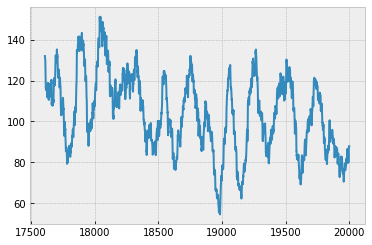

In [106]:
indicator_ec["y_diff"].rolling(80).mean().plot()

The difference graph using the window of 30 is very similar to the above graph.
